In [1]:
import pandas as pd

df = pd.read_csv('jamb_exam_results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Student_ID                    5000 non-null   int64  
 12  Age                           5000 non-null   int64  
 13  Gen

In [2]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
del df['student_id']
df.fillna(0, inplace=True)
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y = 'jamb_score'
y_train = df_train[y].values
y_val = df_val[y].values
y_test = df_test[y].values

del df_train[y]
del df_val[y]
del df_test[y]

In [4]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

X_train.shape

(3200, 29)

In [5]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [6]:
from sklearn.tree import export_text

print(export_text(model, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [156.06]
|--- study_hours_per_week >  18.50
|   |--- value: [188.77]



In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

rmse = root_mean_squared_error(y_val, model.predict(X_val))
rmse

41.60899752457394

In [21]:
for n in range(10, 201, 10):
    model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)

    rmse = root_mean_squared_error(y_val, model.predict(X_val))
    print(n, round(rmse, 3))

10 41.609
20 40.937
30 40.404
40 40.251
50 40.326
60 40.284
70 40.215
80 40.223
90 40.296
100 40.349
110 40.326
120 40.306
130 40.334
140 40.321
150 40.299
160 40.323
170 40.329
180 40.354
190 40.366
200 40.378


In [22]:
import statistics

for m in [10, 15, 20, 25]:
    rmse_list = []
    for n in range(10, 201, 10):
        model = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
        model.fit(X_train, y_train)

        rmse_list.append(root_mean_squared_error(y_val, model.predict(X_val)))

    print(m, statistics.mean(rmse_list))

10 39.90794403669144
15 40.29900102144144
20 40.28907401420218
25 40.40798409299572


<Axes: >

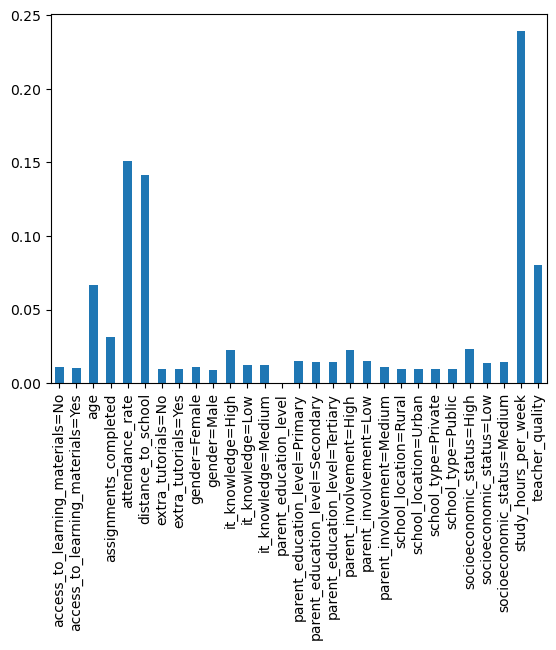

In [31]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

forest_importances = pd.Series(model.feature_importances_, index=dv.get_feature_names_out())
forest_importances.plot.bar()

In [8]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [10]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
rmse

[0]	train-rmse:42.91051	val-rmse:44.64705
[5]	train-rmse:34.71497	val-rmse:40.48899
[10]	train-rmse:31.78525	val-rmse:40.54012
[15]	train-rmse:29.69317	val-rmse:40.75097
[20]	train-rmse:27.74637	val-rmse:41.05446
[25]	train-rmse:26.69254	val-rmse:41.24063
[30]	train-rmse:25.36602	val-rmse:41.56175
[35]	train-rmse:23.83890	val-rmse:41.83701
[40]	train-rmse:22.61671	val-rmse:42.05800
[45]	train-rmse:21.22784	val-rmse:42.33555
[50]	train-rmse:20.48201	val-rmse:42.41658
[55]	train-rmse:19.70262	val-rmse:42.61428
[60]	train-rmse:18.59766	val-rmse:42.97386
[65]	train-rmse:17.71515	val-rmse:43.05034
[70]	train-rmse:16.88900	val-rmse:43.20312
[75]	train-rmse:15.91138	val-rmse:43.19527
[80]	train-rmse:15.18359	val-rmse:43.31768
[85]	train-rmse:14.27913	val-rmse:43.26827
[90]	train-rmse:13.50898	val-rmse:43.49034
[95]	train-rmse:12.82596	val-rmse:43.63100
[99]	train-rmse:12.40000	val-rmse:43.72911


43.72911359403858

In [11]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
rmse

[0]	train-rmse:45.63274	val-rmse:46.87538
[5]	train-rmse:40.31147	val-rmse:42.78603
[10]	train-rmse:37.33867	val-rmse:40.90394
[15]	train-rmse:35.45522	val-rmse:40.12821
[20]	train-rmse:33.95054	val-rmse:39.77532
[25]	train-rmse:32.91152	val-rmse:39.60236
[30]	train-rmse:31.98907	val-rmse:39.43146
[35]	train-rmse:31.22937	val-rmse:39.41851
[40]	train-rmse:30.62475	val-rmse:39.37573
[45]	train-rmse:29.94796	val-rmse:39.44438
[50]	train-rmse:29.22443	val-rmse:39.44678
[55]	train-rmse:28.64287	val-rmse:39.44263
[60]	train-rmse:28.06180	val-rmse:39.48522
[65]	train-rmse:27.55732	val-rmse:39.50587
[70]	train-rmse:27.07405	val-rmse:39.55396
[75]	train-rmse:26.56424	val-rmse:39.67956
[80]	train-rmse:26.21624	val-rmse:39.77869
[85]	train-rmse:25.91962	val-rmse:39.88214
[90]	train-rmse:25.45355	val-rmse:39.97881
[95]	train-rmse:24.87031	val-rmse:40.04154
[99]	train-rmse:24.43915	val-rmse:40.12393


40.12393087961587